In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

#import matplotlib.pyplot as plt
#import numpy as np
#import pandas as pd
#import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
#from tensorflow.keras.layers.experimental import preprocessing
#from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

#from scipy.stats import pearsonr, spearmanr


In [2]:
class Analyzer:
    def __init__(self, num_spins, num_clauses, num_instances, number):
        self.num_spins = num_spins
        self.num_clauses = num_clauses
        self.num_instances = num_instances
        self.number = number
    
    def load_parameters(self):
        with open(
            f'ec3_spins{self.num_spins}_' +
            f'clauses{self.num_clauses}_' +
            f'instances{self.num_instances}_' +
            f'{self.number}.txt', 'r') as text_file:
            params = text_file.read()
            
        params = params.split('\n')
        params = [i.split('=')[1] for i in text[:7]]
        
        self.num_clauses_list = eval(params[1])
        self.num_runs_list = eval(params[3])
        self.temperature_list = eval(params[4])
        self.anneal_T = int(params[5])
        self.anneal_steps = int(params[6])
        
    def load_results(self):
        loaded_npz = np.load(
            f'ec3_spins{self.num_spins}_' +
            f'clauses{self.num_clauses}_' +
            f'instances{self.num_instances}_' +
            f'{self.number}.npz')
        self.res_clauses = loaded_npz['res_clauses']
        self.res_hamiltonian_diag = loaded_npz['res_hamiltonian_diag']
        self.res_mc_samples = loaded_npz['res_mc_samples']
        self.res_fidelity = loaded_npz['res_fidelity']
        
    def distribution(self, sampled_energies, full_energies):
        cnt_full = Counter(full_energies)
        
        
        cnt_mc = Counter(sampled_energies)
        ener = []
        occ = []
        for item in cnt_full:
            ener += [item]
            occ += [cnt_mc[item] / cnt_full[item]]

        ind = np.argsort(ener)
        return np.array(ener)[ind], np.array(occ)[ind]



In [3]:
class Classifier(Analyzer):
    
    def __init__(self, num_spins, num_clauses, num_instances, number):
        # To keep the order of initialization, some booleans are introduced.
        super(Classifier, self).__init__(num_spins, num_clauses, num_instances, number)
        self.dataIsPrepared = False
        self.modelIsPrepared = False
        self.modelIsTrained = False
        self.alreadyReduced = False
        
    def prepare_full_hamiltonian_data(self, binning, test_size = 0.2):
        # Load all the files and as data the full Hamiltonian.
        self.load_results()
        data = self.res_hamiltonian_diag
        
        # Assign some numbers.
        self.N_instance, self.N_feature = data.shape
        self.N_train = int((1-test_size)*self.N_instance)
        self.N_test = int(test_size*self.N_instance)
        
        # Perform min max normalization.
        data = data - data.min()
        data /= data.max() - data.min()
        
        # Load as labels the final fidelity.
        labels = self.res_fidelity[:, -1]
        
        # Set classes for fidelity.
        self.N_categories = binning.shape[0] - 1
        
        # One-hot representation
        bin_rep = np.digitize(labels, binning)
        # Carry on only with fidelities within the binning.
        bin_rep_inner = bin_rep[np.logical_and(bin_rep > 0, bin_rep < len(binning))]
        if len(bin_rep) > len(bin_rep_inner):
            print('Binning excludes data.')
        one_hot_rep = np.identity(len(binning) - 1)[bin_rep_inner - 1]
        
        # Reshape data for the CNN with one channel.
        data_CNN = data.reshape((-1, self.N_feature, 1))
        
        #split train/test data
        X_train, X_test, Y_train, Y_test = train_test_split(
                                            data_CNN, \
                                            one_hot_rep,\
                                            test_size=test_size)
        
        self.X_train, self.X_test = X_train, X_test 
        self.Y_train, self.Y_test = Y_train, Y_test 
        
        self.dataIsPrepared = True
        
    def CNN(self, num_conv, num_pool, drop_out, num_dense, learn_rate):
        # Build up CNN with variable parameter. Ranges should be:
        # num_conv in [4, 8, 16]
        # num_pool in [8, 16, 32]
        # drop_out in [0, .1, .2]
        # num_dense in [16, 32, 64]
        # learn_rate in [0.001, .002, .003]
        
        assert self.dataIsPrepared, "Data not prepared yet. Do CNN_classifier.prepareData()."
        
        tf.keras.backend.clear_session()
        model = keras.Sequential(name='CNN_classifier')
        model.add(layers.Conv1D(1 * num_conv, (3,), activation='relu', padding='same',\
                                input_shape=(self.N_feature, 1)))
        model.add(layers.Conv1D(2 * num_conv, (3,), activation='relu', padding='same'))
        model.add(layers.Conv1D(4 * num_conv, (3,), activation='relu', padding='same'))
        model.add(layers.AveragePooling1D((num_pool,)))
        model.add(layers.Flatten())
        model.add(layers.Dropout(drop_out))
        model.add(layers.Dense(num_dense, activation='relu'))
        model.add(layers.Dense(num_dense, activation='relu'))
        model.add(layers.Dense(self.N_categories, activation=tf.keras.activations.softmax))
        
        model.compile(loss='CategoricalCrossentropy',\
                      optimizer=tf.keras.optimizers.Adam(learn_rate),metrics=['accuracy'])

        self.model = model
        self.modelIsPrepared = True

    #then train the neural network
    def training(self, epochs, batch_size = 128, early = True):
        assert self.modelIsPrepared, "Model not prepared yet. Do CNN_classifier.CNN()."
        
        #introduce early stopping
        stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)
        
        callbacks =[]
        if early:
            callbacks += [stop_early]
    
        self.hist = self.model.fit(self.X_train, self.Y_train, \
                     epochs=epochs,verbose=0,\
                     validation_split=.2,batch_size=batch_size,\
                     callbacks=callbacks)
        self.modelIsTrained = True

    def plotLoss(self):
        assert self.modelIsTrained, "Model not trained yet. Do CNN_classifier.training()."
        plt.semilogy(self.hist.history['loss'], label='loss')
        plt.semilogy(self.hist.history['val_loss'], label = 'val loss')
        plt.xlabel('Epoch')
        plt.legend()
        
    def plotAccuracy(self):
        assert self.modelIsTrained, "Model not trained yet. Do CNN_classifier.training()."
        plt.plot(self.hist.history['accuracy'], label='accuracy')
        plt.plot(self.hist.history['val_accuracy'], label = 'val accuracy')
        plt.xlabel('Epoch')
        plt.legend()
        
    def plotTestPrediction(self):
        assert self.modelIsTrained, "Model not trained yet. Do CNN_classifier.training()."
        plt.hist2d(self.Y_test.argmax(axis=1),\
                   self.model.predict(self.X_test).argmax(axis=1),\
                   bins=self.N_categories);
        plt.xlabel('true')
        plt.ylabel('predict')
        plt.colorbar()
        

In [59]:
classifier = Classifier(7, 6, 1000, 1)

In [60]:
classifier.prepare_full_hamiltonian_data(np.linspace(0, 1, 5))

In [61]:
classifier.CNN(16, 8, 0, 32, .001)

In [62]:
classifier.training(1000)

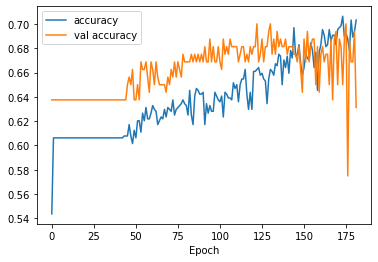

In [63]:
classifier.plotAccuracy()

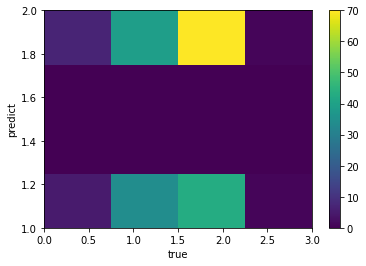

In [64]:
classifier.plotTestPrediction()

In [4]:
lst = []
for num_conv in [8, 16]:
    for num_pool in [8, 16, 32]:
        for drop_out in [0, .1]:
            for num_dense in [32, 64]:
                for learn_rate in [0.001, .002, .003]:

                    classifier = Classifier(7, 4, 1000, 1)
                    classifier.prepare_full_hamiltonian_data(np.linspace(0, 1, 11))
                    classifier.CNN(num_conv, num_pool, drop_out, num_dense, learn_rate)
                    classifier.training(100)
                    
                    avg = np.average(classifier.hist.history['val_accuracy'][-10:])
                    print([num_conv, num_pool, drop_out, num_dense, learn_rate, avg])
                    lst += [[num_conv, num_pool, drop_out, num_dense, learn_rate, avg]]

[8, 8, 0, 32, 0.001, 0.5462500095367432]
[8, 8, 0, 32, 0.002, 0.596875]
[8, 8, 0, 32, 0.003, 0.5306250035762787]
[8, 8, 0, 64, 0.001, 0.5775000035762787]
[8, 8, 0, 64, 0.002, 0.6187500059604645]
[8, 8, 0, 64, 0.003, 0.6275000035762787]
[8, 8, 0.1, 32, 0.001, 0.5381249964237214]
[8, 8, 0.1, 32, 0.002, 0.5418750047683716]
[8, 8, 0.1, 32, 0.003, 0.5737500071525574]
[8, 8, 0.1, 64, 0.001, 0.6393749952316284]
[8, 8, 0.1, 64, 0.002, 0.6318749964237214]
[8, 8, 0.1, 64, 0.003, 0.5900000035762787]
[8, 16, 0, 32, 0.001, 0.5274999976158142]
[8, 16, 0, 32, 0.002, 0.5675000011920929]
[8, 16, 0, 32, 0.003, 0.5956250011920929]
[8, 16, 0, 64, 0.001, 0.5425000071525574]
[8, 16, 0, 64, 0.002, 0.5318750023841858]
[8, 16, 0, 64, 0.003, 0.6075000047683716]
[8, 16, 0.1, 32, 0.001, 0.5093749970197677]
[8, 16, 0.1, 32, 0.002, 0.6481249988079071]
[8, 16, 0.1, 32, 0.003, 0.5662499964237213]
[8, 16, 0.1, 64, 0.001, 0.5581250011920929]
[8, 16, 0.1, 64, 0.002, 0.6162500023841858]
[8, 16, 0.1, 64, 0.003, 0.546875]


In [17]:
lst_arr = np.array(lst)

In [18]:
lst_arr = lst_arr - lst_arr.min(axis = 0)

In [19]:
lst_arr /= lst_arr.max(axis = 0) - lst_arr.min(axis = 0)

In [24]:
lst_arr[:, -1]

array([0.36813189, 0.59065932, 0.29945054, 0.5054945 , 0.68681319,
       0.72527472, 0.33241754, 0.3489011 , 0.489011  , 0.77747249,
       0.74450546, 0.56043956, 0.28571425, 0.46153845, 0.58516482,
       0.35164836, 0.30494504, 0.63736264, 0.20604392, 0.81593404,
       0.45604392, 0.42032965, 0.67582417, 0.3708791 , 0.        ,
       0.16483515, 0.49725271, 0.04395603, 0.59340656, 0.60989011,
       0.29945052, 0.48626368, 0.06868128, 0.39560436, 0.41208792,
       0.27197799, 0.32142857, 0.19505491, 0.59615382, 0.46428568,
       0.66208788, 1.        , 0.6510989 , 0.44780216, 0.43131865,
       0.50824174, 0.48351645, 0.67032967, 0.62362635, 0.88461539,
       0.72802196, 0.69505496, 0.6456044 , 0.66483514, 0.65659338,
       0.52747253, 0.82142852, 0.73626372, 0.37637357, 0.87362636,
       0.65384614, 0.53021979, 0.40109889, 0.26923078, 0.6620879 ,
       0.60989008, 0.10439555, 0.5164835 , 0.49450547, 0.543956  ,
       0.53021974, 0.7362637 ])

In [29]:
lst_arr[lst_arr[:, -1].argmax()]

array([1., 0., 0., 1., 1., 1.])

(array([ 3.,  3.,  6.,  9., 13., 12., 15.,  6.,  4.,  1.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

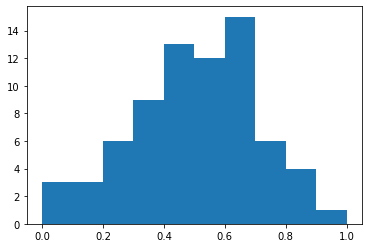

In [25]:
plt.hist(lst_arr[:, -1])

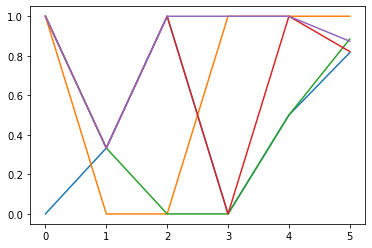

In [28]:
plt.plot(lst_arr[lst_arr[:, -1] > .8].T);

In [2]:
class CNN_classifier():
    #constructor
    def __init__(self):
        self.dataIsPrepared = False
        self.modelIsPrepared = False
        self.modelIsTrained = False
        self.alreadyReduced = False
        
    #load, normalize, and preprocess data
    def prepareData(self, test_size = 0.2):
        assert not self.dataIsPrepared, "Data has been prepared before."
        #load raw data
        diagsN7m5 = pd.read_csv('../../../data/tobias/EC3_data/diagsN7m5.csv',names=np.arange(10000)).T
        fidelsN7m5 = pd.read_csv('../../../data/tobias/EC3_data/fidelsN7m5.csv',names=np.arange(10000)).T
        
        self.N_instance, self.N_feature = diagsN7m5.shape
        self.N_train, self.N_test = int((1-test_size)*self.N_instance), int(test_size*self.N_instance)
        
        #min max normalization
        diagsN7m5 = (diagsN7m5 - diagsN7m5.to_numpy().min())
        diagsN7m5 /= (diagsN7m5.to_numpy().max() - diagsN7m5.to_numpy().min())
        
        #determine categories
        uni_fidels = np.sort(fidelsN7m5[0].unique())
        self.N_categories = uni_fidels.shape[0]
        
        #create one hot representation
        one_hot_fidels = pd.DataFrame()
        for uni_fidel in uni_fidels:
            one_hot_fidels[uni_fidel] = 1*(fidelsN7m5 == uni_fidel).to_numpy().flatten()
        
        #prepare data for CNN with one channel and normalized
        diags_CNN = diagsN7m5.to_numpy().reshape((-1,self.N_feature,1))
        state_CNN = np.linspace(0,1,self.N_feature)\
        .repeat(self.N_instance)\
        .reshape(self.N_feature,self.N_instance).T\
        .reshape((-1,self.N_feature,1))
        diags_CNN_twoChannel = np.append(diags_CNN,state_CNN,axis=2)
        
        #split train/test data
        X_train, X_test, Y_train, Y_test = train_test_split(diags_CNN_twoChannel, \
                                                     one_hot_fidels,\
                                                     test_size=test_size)

        self.X_train, self.X_test, self.Y_train, self.Y_test = X_train, X_test, Y_train, Y_test 
        self.dataIsPrepared = True
        
    
        
    #first construct and compile the neural network    
    def CNN(self):
        assert self.dataIsPrepared, "Data not prepared yet. Do CNN_classifier.prepareData()."
        
        #build up CNN with hard-coded hyperparameters
        tf.keras.backend.clear_session()
        model = keras.Sequential(name='CNN_classifier')
        model.add(layers.Conv1D(8, (3,), activation='relu', padding='same',\
                                input_shape=(self.N_feature, 2)))
        model.add(layers.Conv1D(16, (3,), activation='relu', padding='same'))
        model.add(layers.Conv1D(32, (3,), activation='relu', padding='same'))
        model.add(layers.AveragePooling1D((16,)))
        model.add(layers.Flatten())
        model.add(layers.Dropout(.0))
        model.add(layers.Dense(32, activation='relu'))
        model.add(layers.Dense(32, activation='relu'))
        model.add(layers.Dense(self.N_categories, activation=tf.keras.activations.softmax))
        
        model.compile(loss='CategoricalCrossentropy',\
                      optimizer=tf.keras.optimizers.Adam(.002),metrics=['accuracy'])

        self.model = model
        self.modelIsPrepared = True

    #then train the neural network
    def training(self, epochs, batch_size = 128, early = True):
        assert self.modelIsPrepared, "Model not prepared yet. Do CNN_classifier.CNN()."
        
        #introduce early stopping
        stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)
        
        callbacks =[]
        if early:
            callbacks += [stop_early]
    
        self.hist = self.model.fit(self.X_train, self.Y_train, \
                     epochs=epochs,verbose=0,\
                     validation_split=.2,batch_size=batch_size,\
                     callbacks=callbacks)
        self.modelIsTrained = True

    def plotLoss(self):
        assert self.modelIsTrained, "Model not trained yet. Do CNN_classifier.training()."
        plt.semilogy(self.hist.history['loss'], label='loss')
        plt.semilogy(self.hist.history['val_loss'], label = 'val loss')
        plt.xlabel('Epoch')
        plt.legend()
        
    def plotAccuracy(self):
        assert self.modelIsTrained, "Model not trained yet. Do CNN_classifier.training()."
        plt.plot(self.hist.history['accuracy'], label='accuracy')
        plt.plot(self.hist.history['val_accuracy'], label = 'val accuracy')
        plt.xlabel('Epoch')
        plt.legend()
        
    def plotTestPrediction(self):
        assert self.modelIsTrained, "Model not trained yet. Do CNN_classifier.training()."
        plt.hist2d(self.Y_test.to_numpy().argmax(axis=1),\
                   self.model.predict(self.X_test).argmax(axis=1),\
                   bins=self.N_categories);
        plt.xlabel('true')
        plt.ylabel('predict')
        plt.colorbar()
        
        

In [3]:
classifier = CNN_classifier()

In [ ]:
classifier.